<a name='1'></a>
# 1 Intro #

In [2]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import scipy.sparse.linalg

<a name='1.1'></a>
## 1.1 - Load the data

Remember that to apply PCA on any dataset you will begin by defining the covariance matrix. After that you will compute the eigenvalues and eigenvectors of this covariance matrix. Each of these eigenvectors will be a **principal component**. To perform the dimensionality reduction, you will take the $k$ principal components associated to the $k$ biggest eigenvalues, and transform the original data by projecting it onto the direction of these principal components (eigenvectors).


In [3]:
def load_images(directory):
    images = []
    for filename in glob.glob(directory+'*.jpg'):
        img = np.array(image.imread(filename))
        gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images.append(gimg)
        # height, width = gimg.shape
    return images

In [4]:
imgs = load_images('./cats/')
cat1 = imgs[0]

In [5]:
height, width = imgs[0].shape

print(
    f'\nYour dataset has {len(imgs)} images of size {height}x{width} pixels\n')


Your dataset has 55 images of size 64x64 pixels



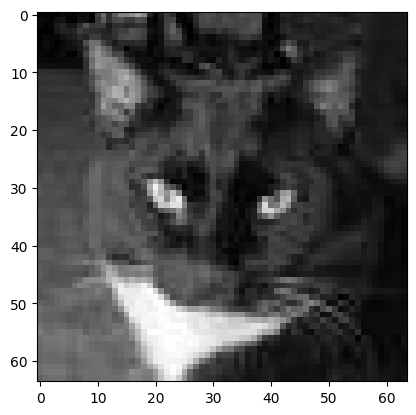

In [6]:
plt.imshow(cat1, cmap='gray')

When working with images, you can consider each pixel as a variable. Having each image in matrix form is good for visualizing the image, but not so much for operating on each variable. 

In order to apply PCA for dimensionality reduction you will need to flatten each image into a single row vector. You can do this using the `reshape` function from NumPy. 

The resulting array will have 55 rows, one for each image, and 64x64=4096 columns.

In [7]:
imgs_flatten = np.array([im.reshape(-1) for im in imgs])

print(f'imgs_flatten shape: {imgs_flatten.shape}')

imgs_flatten shape: (55, 4096)


<a name='2'></a>
# 2 - Get the covariance matrix

In [8]:
def center_data(Y):
    """
    Center your original data
    Args:
         Y (ndarray): input data. Shape (n_observations x n_pixels)
    Outputs:
        X (ndarray): centered data
    """
    mean_vector = np.mean(Y, axis=0)  # column-wise mean
    print(f'mean_vector shape: {mean_vector.shape}')
    mean_matrix = np.reshape(mean_vector, (1, -1))
    print(f'mean_matrix shape: {mean_matrix.shape}')
    # use np.reshape to reshape into a matrix with the same size as Y. Remember to use order='F'
    X = Y - mean_matrix
    print(f'X shape: {X.shape}')
    return X

mean_vector shape: (4096,)
mean_matrix shape: (1, 4096)
X shape: (55, 4096)


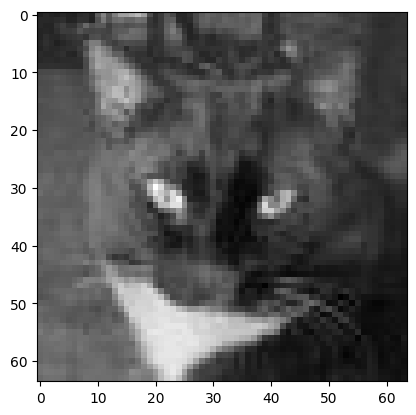

In [9]:
X = center_data(imgs_flatten)
plt.imshow(X[0].reshape(64, 64), cmap='gray')

In [10]:
cov_matrix = np.cov(X, rowvar=False)
print(f'Covariance matrix shape: {cov_matrix.shape}')

Covariance matrix shape: (4096, 4096)


<a name='3'></a>
# 3 - Compute the eigenvalues and eigenvectors

Now you are all set to compute the eigenvalues and eigenvectors of the covariance matrix.
Due to performance constaints, you will not be using `np.linalg.eig`, but rather the very similar function [`scipy.sparse.linalg.eigsh`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html), which exploits the fact that $\mathrm{cov\_matrix}^T=\mathrm{cov\_matrix}$. Also, this function allows you to compute fewer number of eigenvalue-eigenvector pairs. 

It is outside of the scope of this course, but it can be shown that at most 55 eigenvalues of `cov_matrix` will be different from zero, which is the smallest dimension of the data matrix `X`. Thus, for computational efficiency, you will only be computing the first biggest 55 eigenvalues $\lambda_1, \ldots, \lambda_{55}$ and their corresponding eigenvectors $v_1, \ldots, v_{55}$. Feel free to try changing the `k` parameter in `scipy.sparse.linalg.eigsh` to something slightly bigger, to verify that all the new eigenvalues are zero. Try to keep it below 80, otherwise it will take too long to compute. 

The outputs of this scipy function are exactly the same as the ones from `np.linalg.eig`, except eigenvalues are ordered in decreasing order, so if you want to check out the largest eigenvalue you need to look into the last position of the vector. 

In [11]:
np.random.seed(7)
eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(cov_matrix, k=55)
print(f'eigenvals shape: {eigenvals.shape}')
print(f'eigenvecs shape: {eigenvecs.shape}')

eigenvals shape: (55,)
eigenvecs shape: (4096, 55)


In [12]:
print(f'Ten largest eigenvalues: \n{eigenvals[-10:]}')

Ten largest eigenvalues: 
[ 293228.19669624  383726.58867454  399184.59618649  479311.0892984
  839689.08870292  878711.73402995 1011093.05519076 1536617.26289103
 2483710.87630303 4199357.2773408 ]


The random seed is fixed in the code above to help ensure the same eigenvectors are calculated each time. This is because for each eigenvector, there are actually two possible outcomes with norm 1. They fall on the same line but point in opposite directions. An example of this would be the vectors 

$$\begin{bmatrix}0.25 \\0.25 \\ -0.25 \\ 0.25 \end{bmatrix} \text{and } \begin{bmatrix}-0.25 \\ -0.25 \\ 0.25 \\ -0.25 \end{bmatrix}.$$

Both possibilities are correct, but by fixing the seed you guarantee you will always get the same result. 

In order to get a consistent result with `np.linalg.eig`, you will invert the order of `eigenvals` and `eigenvecs`, so they are both ordered from largest to smallest eigenvalue.

In [13]:
eigenvals = eigenvals[::-1]
eigenvecs = eigenvecs[:, ::-1]

print(f'Ten largest eigenvalues: \n{eigenvals[:10]}')

Ten largest eigenvalues: 
[4199357.2773408  2483710.87630303 1536617.26289103 1011093.05519076
  878711.73402995  839689.08870292  479311.0892984   399184.59618649
  383726.58867454  293228.19669624]


Each of the eigenvectors you found will represent one principal component. The eigenvector associated with the largest eigenvalue will be the first principal component, the eigenvector associated with the second largest eigenvalue will be the second principal component, and so on. 

It is pretty interesting to see that each principal component usually extracts some relevant features, or patterns from each image. In the next cell you will be visualizing the first sixteen components

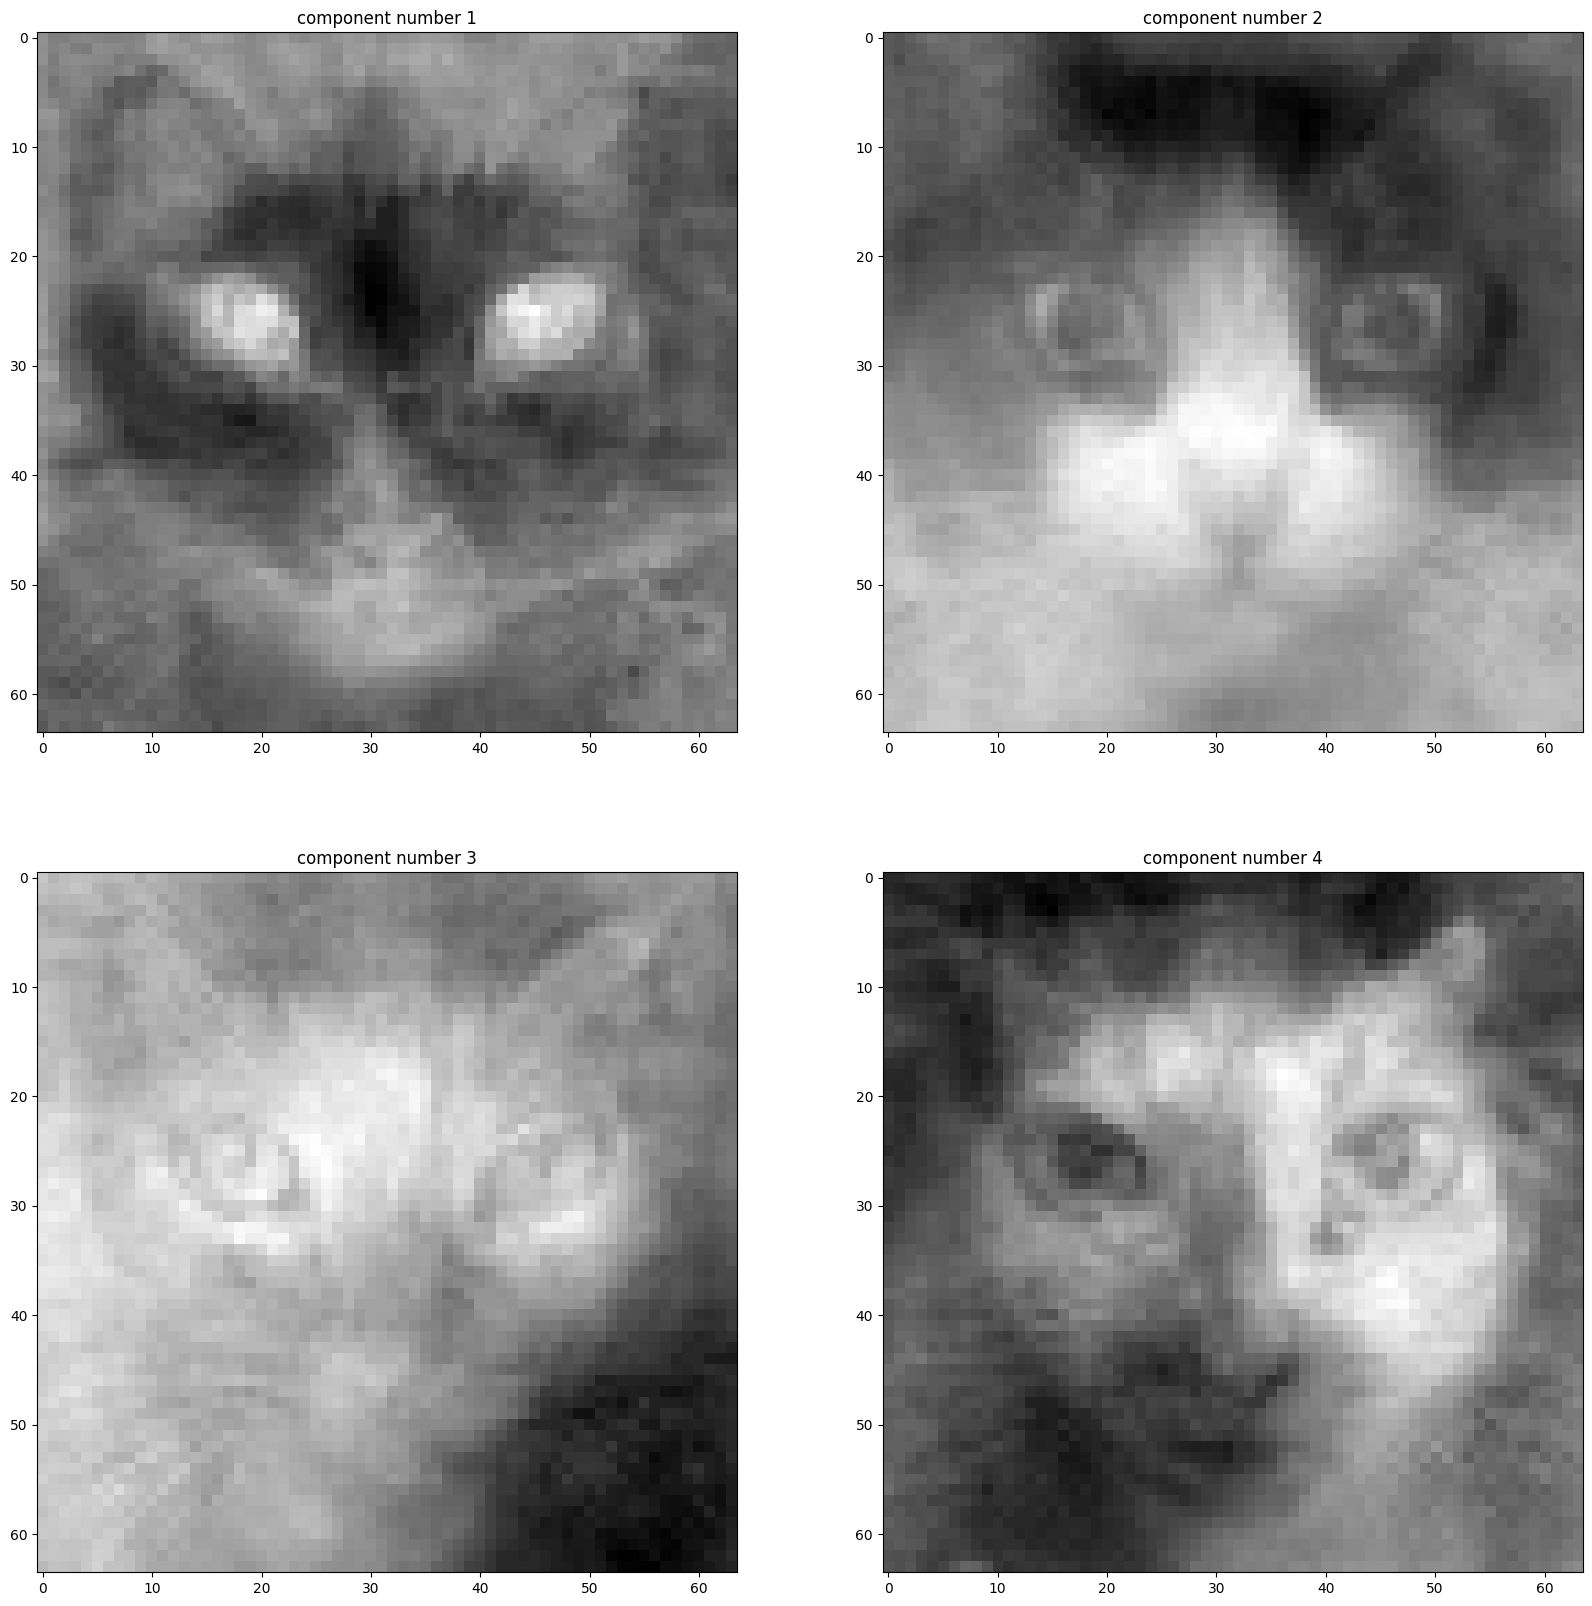

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for n in range(2):
    for k in range(2):
        ax[n, k].imshow(
            eigenvecs[:, n*2+k].reshape(height, width), cmap='gray')
        ax[n, k].set_title(f'component number {n*2+k+1}')

<a name='3'></a>
# 3 - Perform PCA

In [15]:
def perform_PCA(X, eigenvecs, k):
    """
    Perform dimensionality reduction with PCA
    Inputs:
        X (ndarray): original data matrix. Has dimensions (n_observations)x(n_variables)
        eigenvecs (ndarray): matrix of eigenvectors. Each column is one eigenvector. The k-th eigenvector 
                            is associated to the k-th eigenvalue
        k (int): number of principal components to use
    Returns:
        Xred
    """

    V = eigenvecs[:, :k]
    Xred = np.dot(X, V)
    return Xred

In [16]:
Xred2 = perform_PCA(X, eigenvecs, 2)
print(f'Xred2 shape: {Xred2.shape}')

Xred2 shape: (55, 2)


<a name='3.2'></a>
## 3.2 Reconstructing the images from the eigenvectors

When you compress the images using PCA, you are losing some information because you are using fewer variables to represent each observation. 

A natural question arises: how many components do you need to get a good reconstruction of the image? Of course, what determines a "good" reconstruction might depend on the application.

A cool thing is that with a simple dot product you can transform the data after applying PCA back to the original space. This means that you can reconstruct the original image from the transformed space and check how distorted it looks based on the number of components you kept.

Suppose you obtained the matrix $X_{red}$ by keeping just two eigenvectors, then $X_{red} = \mathrm{X}\underbrace{\left[v_1\  v_2\right]}_{\boldsymbol{V_2}}$.

To transform the images back to the original variables space all you need to do is take the dot product between $X_{red}$ and $\boldsymbol{V_2}^T$. If you were to keep more components, say $k$, then simply replace $\boldsymbol{V_2}$ by $\boldsymbol{V_k} = \left[v_1\ v_2\ \ldots\ v_k\right]$. Notice that you can't make any combination you like, if you reduced the original data to just $k$ components, then the recovery must consider only the first $k$ eigenvectors, otherwise you will not be able to perfrom the matrix multiplication.

In the next cell you will define a function that given the transformed data $X_{red}$ and the matrix of eigenvectors returns the recovered image. 

In [17]:
# X shape
print(f'X shape: {X.shape}')
# eigenvecs shape
print(f'eigenvecs shape: {eigenvecs.shape}')
ev2 = eigenvecs[:, :2]
print(f'ev2 shape: {ev2.shape}')
# Xred2 shape
print(f'Xred2 shape: {Xred2.shape}')

X shape: (55, 4096)
eigenvecs shape: (4096, 55)
ev2 shape: (4096, 2)
Xred2 shape: (55, 2)


In [18]:
def reconstruct_image(Xred, eigenvecs):
    X_reconstructed = Xred.dot(eigenvecs[:, :Xred.shape[1]].T)

    return X_reconstructed

Text(0.5, 1.0, 'reconstructed from 30 components')

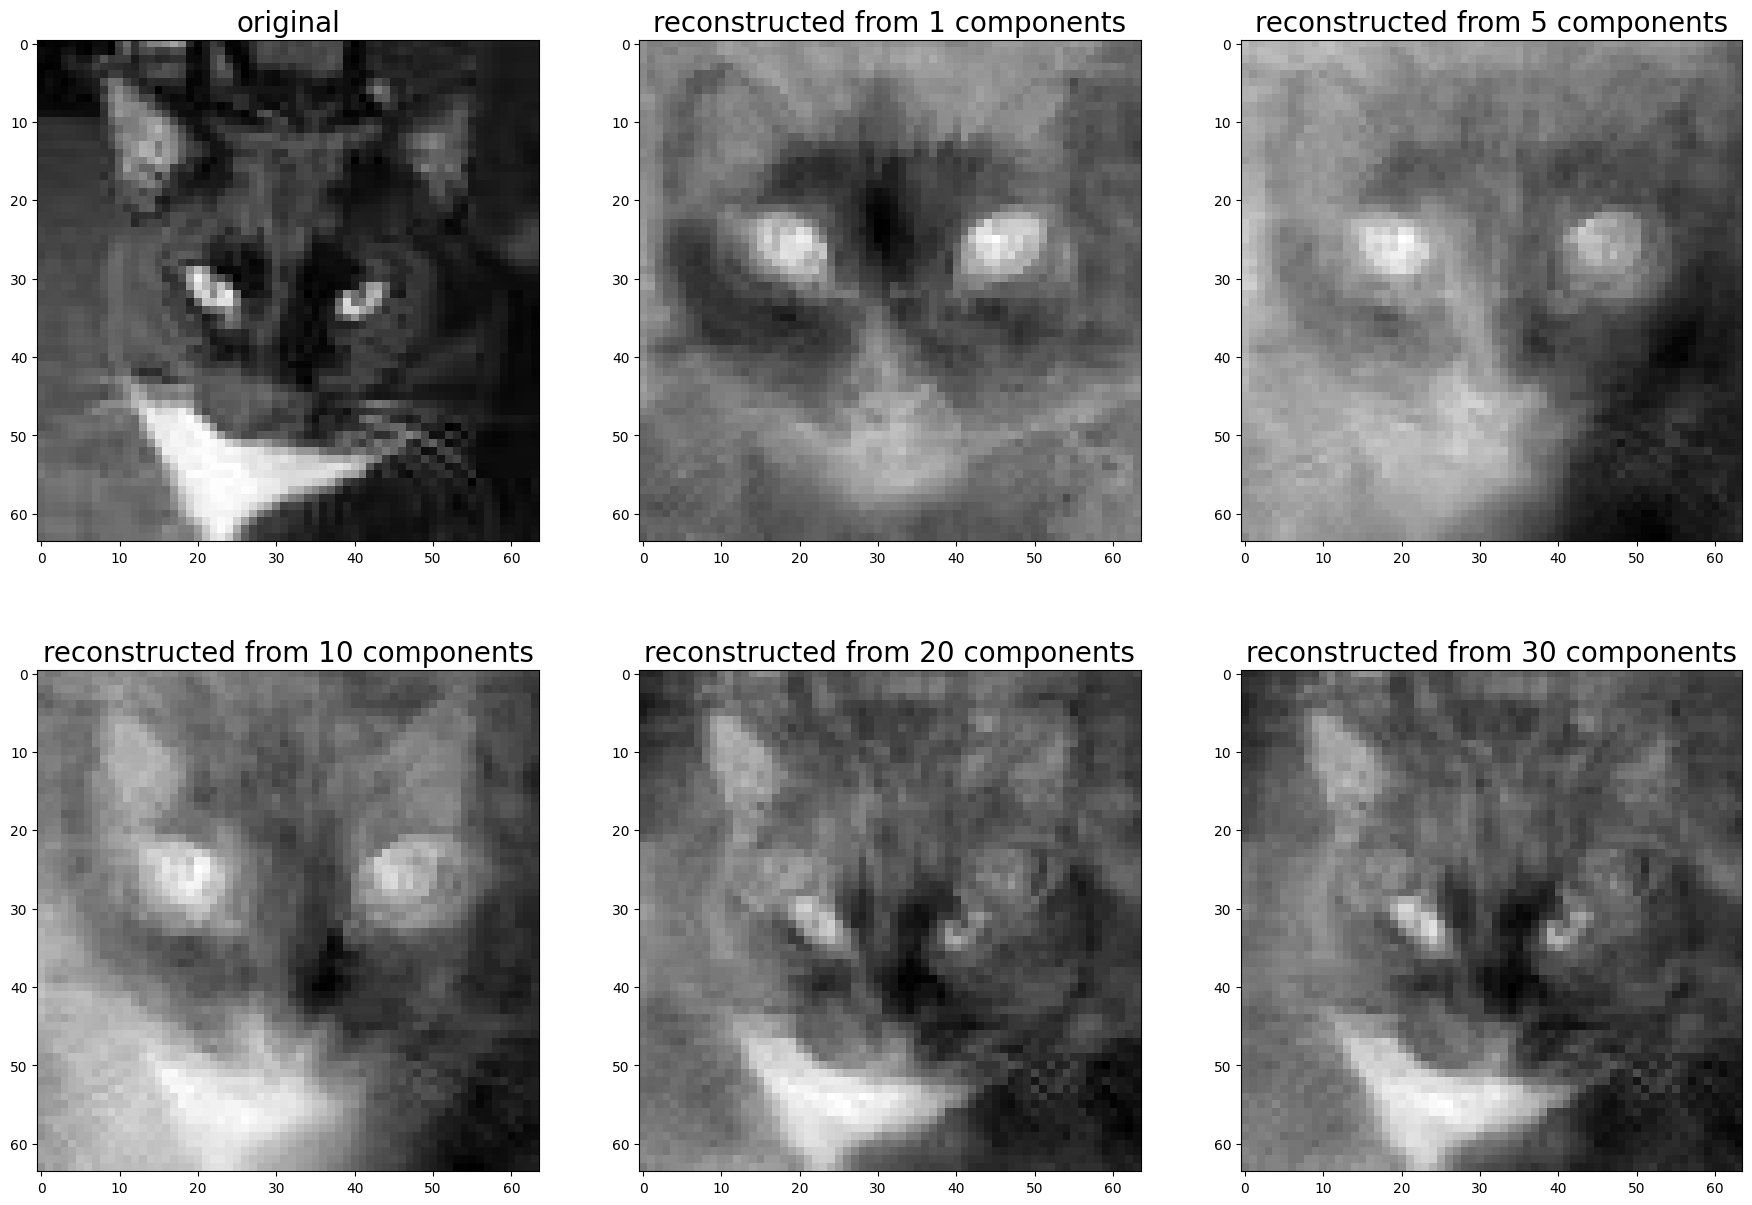

In [19]:
Xred1 = perform_PCA(X, eigenvecs, 1)  # reduce dimensions to 1 component
Xred5 = perform_PCA(X, eigenvecs, 5)  # reduce dimensions to 5 components
Xred10 = perform_PCA(X, eigenvecs, 10)  # reduce dimensions to 10 components
Xred20 = perform_PCA(X, eigenvecs, 20)  # reduce dimensions to 20 components
Xred30 = perform_PCA(X, eigenvecs, 30)  # reduce dimensions to 30 components
# reconstruct image from 1 component
Xrec1 = reconstruct_image(Xred1, eigenvecs)
# reconstruct image from 5 components
Xrec5 = reconstruct_image(Xred5, eigenvecs)
# reconstruct image from 10 components
Xrec10 = reconstruct_image(Xred10, eigenvecs)
# reconstruct image from 20 components
Xrec20 = reconstruct_image(Xred20, eigenvecs)
# reconstruct image from 30 components
Xrec30 = reconstruct_image(Xred30, eigenvecs)

fig, ax = plt.subplots(2, 3, figsize=(22, 15))
mm = 0
ax[0, 0].imshow(imgs[mm], cmap='gray')
ax[0, 0].set_title('original', size=20)
ax[0, 1].imshow(Xrec1[mm].reshape(height, width), cmap='gray')
ax[0, 1].set_title('reconstructed from 1 components', size=20)
ax[0, 2].imshow(Xrec5[mm].reshape(height, width), cmap='gray')
ax[0, 2].set_title('reconstructed from 5 components', size=20)
ax[1, 0].imshow(Xrec10[mm].reshape(height, width), cmap='gray')
ax[1, 0].set_title('reconstructed from 10 components', size=20)
ax[1, 1].imshow(Xrec20[mm].reshape(height, width), cmap='gray')
ax[1, 1].set_title('reconstructed from 20 components', size=20)
ax[1, 2].imshow(Xrec30[mm].reshape(height, width), cmap='gray')
ax[1, 2].set_title('reconstructed from 30 components', size=20)

It works because of how PCA projects and reconstructs data:

When you do x_res = X * V, you are projecting your original data X onto the new basis formed by the selected eigenvectors V. This gives you the coordinates of your data in the principal component space (lower-dimensional representation).

To reconstruct the data, you need to go back from the principal component space to the original space. The principal components (eigenvectors) form an orthonormal basis, so you can reverse the projection by multiplying by the transpose: x_res * V.T.

Mathematically, if V is an orthonormal matrix (its columns are eigenvectors), then projecting and reconstructing works like this:

Project: X_projected = X * V
Reconstruct: X_reconstructed = X_projected * V.T
This is because the dot product with V changes the basis, and the dot product with V.T transforms it back. If you use all eigenvectors, you get the original data back. If you use only some, you get an approximation.

## 3.3 Visualizing PCA Compression on a Single Image

In [34]:
import numpy as np


def pca_compress_image(img, num_components):
    """
    Compress a single grayscale image using PCA.
    Args:
        img (ndarray): 2D image array (height x width)
        num_components (int): Number of principal components to keep
    Returns:
        compressed (ndarray): Compressed representation (num_components,)
        components (ndarray): Principal components (height*width, num_components)
        mean_vector (ndarray): Mean vector (height*width,)
    """
    # Center data
    mean_vector = np.mean(img, axis=0)
    img_centered = img - mean_vector
    # Covariance matrix (since only one image, use outer product)
    cov_matrix = np.cov(img_centered, rowvar=False)
    print(f'Covariance matrix shape: {cov_matrix.shape}')
    # Eigen decomposition
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
    # print
    print(f'Eigenvalues shape: {eigenvals.shape}')
    print(f'Eigenvectors shape: {eigenvecs.shape}')
    # Sort by descending eigenvalue
    idx = np.argsort(eigenvals)[::-1]
    eigenvecs = eigenvecs[:, idx]
    # Select top components
    components = eigenvecs[:, :num_components]
    print(f'Components shape: {components.shape}')
    # Project image
    compressed = np.dot(img_centered, components)

    # reconstruct image
    reconstructed = np.dot(compressed, components.T)
    return compressed, components, reconstructed

In [39]:
cat1 = imgs[0]
# Resize image to 100x100
K = 100
small_img = cv2.resize(cat1, (K, K), interpolation=cv2.INTER_AREA)
compressed, components, reconstructed = pca_compress_image(small_img, 10)
print(f'small_img shape: {small_img.shape}')
print(f'Compressed shape: {compressed.shape}')
reconstructed = reconstructed.reshape(K, K)

Covariance matrix shape: (100, 100)
Eigenvalues shape: (100,)
Eigenvectors shape: (100, 100)
Components shape: (100, 10)
small_img shape: (100, 100)
Compressed shape: (100, 10)


(-0.5, 99.5, 99.5, -0.5)

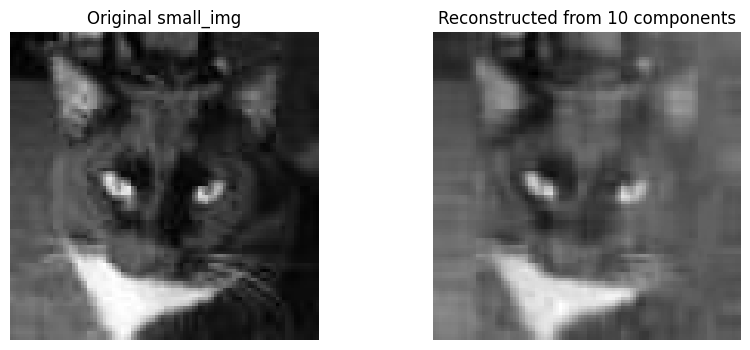

In [40]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(small_img, cmap='gray')
plt.title('Original small_img')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstructed from 10 components')
plt.axis('off')